# Setting up

In [1]:
import cv2
import numpy as np
import os         
from random import shuffle 
from tqdm import tqdm      
import tensorflow as tf
import matplotlib.pyplot as plt

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

%matplotlib inline

TRAIN_DIR = 'train'
TEST_DIR = 'test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogs-vs-cats-convnet'

# Image preprocessing

We have 25,000 images for training and 12,500 for testing. Let's create a function that encodes the labels of the training images: 

In [2]:
def create_label(image_name):
    """ Create an one-hot encoded vector from image name """
    word_label = image_name.split('.')[-3]
    if word_label == 'cat':
        return np.array([1,0])
    elif word_label == 'dog':
        return np.array([0,1])

A function that reads the training images, remove the color and resize them to 50x50 pixels:

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR, img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img_data), create_label(img)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [4]:
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img_data), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

Now, let's split the data. 24,500 images for training and 500 for testing:

In [5]:
# If dataset is not created:
train_data = create_train_data()
test_data = create_test_data()

# If you have already created the dataset:
# train_data = np.load('train_data.npy')
# test_data = np.load('test_data.npy)

train = train_data[:-500]
test = train_data[-500:]

X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = [i[1] for i in train]

X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = [i[1] for i in test]

100%|██████████| 12500/12500 [00:11<00:00, 1051.73it/s]


# Convolutional Neural Nets

<div class="center">
    <iframe width="100%" height="360" src="https://www.youtube.com/embed/FmpDIaiMIeA" frameborder="0" allowfullscreen></iframe>
</div>

# Building our model

Next, the fun part begins. We will use [tflearn](http://tflearn.org/) to build our convnet model. Additional bonus, we will use *Dropout*.

In [6]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)

model.fit({'input': X_train}, {'targets': y_train}, n_epoch=3, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 11.29136 | time: 28.758s
| Adam | epoch: 003 | loss: 11.29136 - acc: 0.5096 -- iter: 24448/24500
Training Step: 1149  | total loss: 11.24156 | time: 29.829s
| Adam | epoch: 003 | loss: 11.24156 - acc: 0.5118 | val_loss: 12.15765 - val_acc: 0.4720 -- iter: 24500/24500
--


Flipping a coin might be a better model than this one. Let's go bigger and better (hopefully):

In [7]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)

model.fit({'input': X_train}, {'targets': y_train}, n_epoch=3, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.42927 | time: 31.296s
| Adam | epoch: 003 | loss: 0.42927 - acc: 0.8076 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.43193 | time: 32.378s
| Adam | epoch: 003 | loss: 0.43193 - acc: 0.8066 | val_loss: 0.46819 - val_acc: 0.7720 -- iter: 24500/24500
--


# Did we did well?

Let's have a look at a single prediction:

cat: 0.013666120357811451, dog: 0.9863339066505432


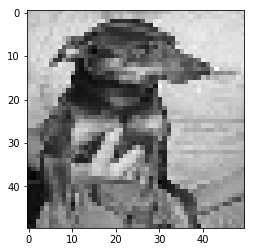

In [8]:
d = test_data[0]
img_data, img_num = d

data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
prediction = model.predict([data])[0]

plt.imshow(img_data, cmap="gray")
print(f"cat: {prediction[0]}, dog: {prediction[1]}")

Now, for 16 predictions:

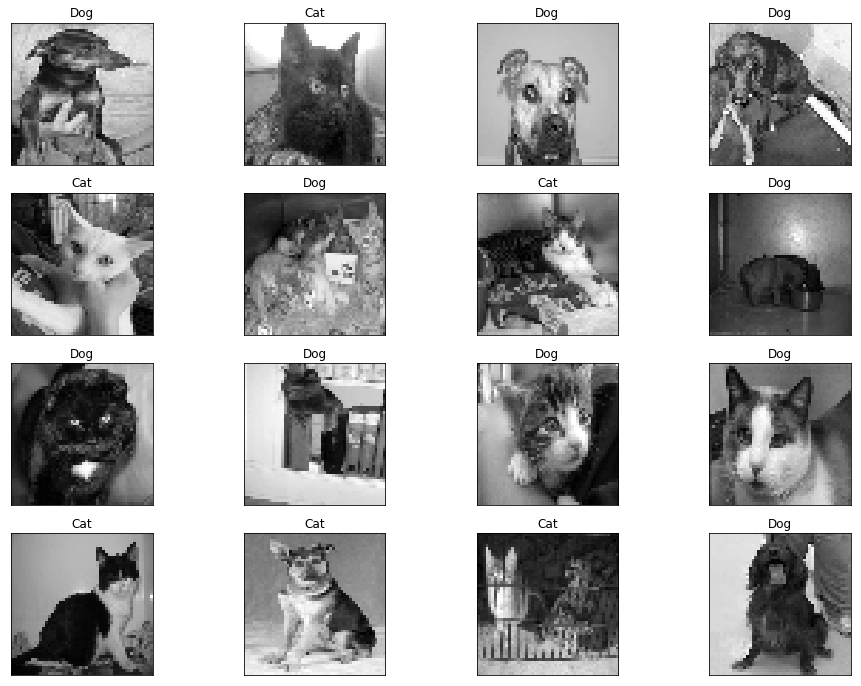

In [9]:
fig=plt.figure(figsize=(16, 12))

for num, data in enumerate(test_data[:16]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else:
        str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()